# Thai Classical Music Motif Analysis – Proof of Concept (Desc)





## 1. Data Loading & Corpus Overview
- Load JSON / MIDI-derived symbolic data  
- Basic stats (songs per motif, bars per song)

## 2. Symbolic Normalization
- Note vocabulary definition
- Rest handling
- Octave / ornament normalization
- Sequence flattening (bar → token stream)

## 3. Feature Extraction
### 3.1 Note-Level Statistics
- Pitch histogram
- Interval distribution

### 3.2 N-gram Extraction
- Unigram / Bigram / Trigram counts
- Per-motif aggregation

### 3.3 Contour Representation (optional)
- Up / Down / Same encoding
- Contour n-grams

## 4. Motif Similarity Analysis
- Feature vector construction
- Cosine / KL similarity
- Song-to-song and motif-level similarity

## 5. Motif Classification (Baseline)
- Train / validation split
- Linear models (LogReg / SVM)
- Confusion matrix & accuracy

## 6. Visualization
- N-gram heatmaps
- PCA / UMAP motif clustering

## 7. Discussion (Preliminary Findings)
- Observed motif patterns
- Limitations (small data, single layer)
- Implications for Stage 2 tagging

## 8. Next Steps
- Dataset expansion
- Audio features (MFCC / chroma)
- Conditional generation pipeline


#


# Thai Classical Music Motif Analysis – Code


## 0. Environment Setup (once per runtime)




In [1]:
!pip install mido python-rtmidi


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf


--2026-02-22 19:49:48--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2026-02-22 19:49:49--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.6’

thsarabunnew-webfon 100%[===================>]  96.00K   232KB/s    in 0.4s    

2026-02-22 19:49:50 (232 KB/s) - ‘

In [ ]:
# !git clone https://github.com/GetomG/Thai-Music-Thesis.git
# If already cloned:
# !git pull

In [ ]:
# Enter project folder
# %cd Thai-Music-Thesis

In [ ]:
# !pwd

/Users/thanakrit/Documents/Thai Music Thesis


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Properly load Sarabun font
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')

# Clear font cache to recognize new font
import matplotlib.font_manager as fm
fm.fontManager.addfont('thsarabunnew-webfont.ttf')

# Apply font globally
mpl.rcParams['font.family'] = 'TH Sarabun New'
mpl.rcParams["axes.unicode_minus"] = False

# For plots, ensure font is used
plt.rcParams['font.family'] = 'TH Sarabun New'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Helpers Libs


In [4]:
# ============================================================
# 2. I/O Utilities
# ============================================================
from thai_music_utils.io_utils import (
    save_json_bar_per_line
)

# ============================================================
# 3. Notation Processing
# - Flatten JSON → tokens
# - Normalize octave markers
# - Convert to continuous sequence string
# ============================================================
from thai_music_utils.notation_utils import (
    flatten_song_notation,
    normalize_octave_markers,
    notation_to_sequence
)

# ============================================================
# 4. Octave Inference (DP-based register guessing)
# ============================================================
from thai_music_utils.octave_inference import (
    is_thai_note,
    get_fixed_octave,
    guess_octaves_with_constraints,
    add_octaves_respecting_labels
)

# ============================================================
# 5. Preprocessing Utilities
# ============================================================
from thai_music_utils.preprocessing import (
    flatten_song_data,
    remove_all_signs
)

# ============================================================
# 6. MIDI Rendering (Ranad-specific)
# ============================================================
from thai_music_utils.midi_ranad import (
    generate_ranad_midi
)

# ============================================================
# 7. EDA Helpers (Symbolic Analysis)
# ============================================================
from thai_music_utils.eda_symbolic_normalization import (
    normalize_token,
    normalize_bar,
    flatten_song,
    THAI_NOTES,
    UP_MARK,
    LOW_MARK,
    REST_TOKEN
)

from thai_music_utils.eda_stats import (
    extract_symbols,
    pitch_stats,
    stats_to_df
)

## 1. Data Loading & Corpus Overview
- Load JSON / MIDI-derived symbolic data  
- Basic stats (songs per motif, bars per song)


In [5]:
import json
from pathlib import Path
from collections import defaultdict

# BASE = Path("/content/drive/MyDrive/thai_music_data/songs")
BASE = Path("./thai_music_data/songs")

songs = []

for motif_dir in BASE.iterdir():
    if not motif_dir.is_dir():
        continue

    motif = motif_dir.name

    for song_dir in motif_dir.iterdir():
        json_dir = song_dir / "json"
        if not json_dir.exists():
            continue

        for json_file in json_dir.glob("*.json"):
            try:
                with open(json_file, "r", encoding="utf-8") as f:
                    data = json.load(f)

                songs.append({
                    "motif": motif,
                    "song": song_dir.name,
                    "path": str(json_file),
                    "data": data
                })

            except Exception as e:
                print(f"⚠️ Skipped {json_file}: {e}")

In [6]:
print(f"Total songs loaded: {len(songs)}")

by_motif = defaultdict(int)
for s in songs:
    by_motif[s["motif"]] += 1

for motif, n in by_motif.items():
    print(f"{motif}: {n} songs")

Total songs loaded: 44
เขมร: 7 songs
จีน: 4 songs
พม่า: 5 songs
ลาว: 18 songs
ไทยเดิม: 2 songs
แขก: 8 songs


In [7]:
from pathlib import Path

# BASE = Path("/content/drive/MyDrive/thai_music_data/songs")

for motif_dir in BASE.iterdir():
    if not motif_dir.is_dir():
        continue

    for song_dir in motif_dir.iterdir():
        json_dir = song_dir / "json"
        if not json_dir.exists():
            continue

        json_files = sorted(p.name for p in json_dir.glob("*.json"))
        if not json_files:
            continue

        print(f"{motif_dir.name}/{song_dir.name}:")
        for jf in json_files:
            print(f"  - {jf}")

เขมร/เขมรโพธิสัตว์:
  - เขมรโพธิสัตว์_full.json
เขมร/เขมรไทรโยค:
  - เขมรไทรโยค_full.json
เขมร/เขมรพวง:
  - เขมรพวง_full.json
เขมร/เขมรลออองค์:
  - เขมรลออองค์_full.json
เขมร/เขมรปากท่อ:
  - เขมรปากท่อ_full.json
เขมร/เขมรชนบท:
  - เขมรชนบท_full.json
เขมร/เขมรพายเรือ:
  - เขมรพายเรือ_full.json
จีน/จีนฮ่อแห่:
  - จีนฮ่อแห่_full.json
จีน/จีนเก็บบุปผา:
  - จีนเก็บบุปผา_full.json
จีน/จีนไจ๋ยอ:
  - จีนไจ๋ยอ_full.json
จีน/จีนขิมเล็ก:
  - จีนขิมเล็ก_full.json
พม่า/พม่าเขว:
  - พม่าเขว_manual.json
พม่า/พม่ากลองยาว:
  - พม่ากลองยาว_manual.json
พม่า/พม่าปองเงาะ:
  - พม่าปองเงาะ_manual.json
พม่า/พม่าแปลง:
  - พม่าแปลง_full.json
พม่า/แร้งกระพือปีก:
  - แร้งกระพือปีก_manual.json
ลาว/ลาวกระทบไม้:
  - ลาวกระทบไม้_full.json
ลาว/ลาวกระแต:
  - ลาวกระแต_full.json
ลาว/ลาวเสี่ยงเทียน:
  - ลาวเสี่ยงเทียน_manual.json
ลาว/ลาวดวงดอกไม้:
  - ลาวดวงดอกไม้_manual.json
ลาว/ลาวเสี่ยงเทียน (เถา):
  - ลาวเสี่ยงเทียน (เถา)_full.json
ลาว/ลาวดำเนินทราย:
  - ลาวดำเนินทราย_manual.json
ลาว/ลาวจ้อย:
  - ลาวจ้อย_manual.json
ล

## 2. Symbolic Normalization (preprocessing)
- Note vocabulary definition
- Rest handling
- Octave / ornament normalization
- Sequence flattening (bar → token stream)


In [8]:
# ----------------------------
# Apply normalization to corpus
# ----------------------------
for s in songs:
    try:
        # Store normalized symbolic sequence WITHOUT overwriting raw data
        s["sequence"] = flatten_song(s["data"])
    except Exception as e:
        # Fault-tolerant: broken JSON → empty sequence
        print(f"⚠️ Normalization failed for {s['song']}: {e}")
        s["sequence"] = []


# ----------------------------
# Sanity check (inspect output)
# ----------------------------
songs[29]["sequence"][:40]

['----',
 '----',
 'มํซํรํ',
 'มํรํดํล',
 'ดํ',
 'ลลล',
 'มํซํรํ',
 'มํรํดํล',
 'ดํล',
 'ซมซล',
 'ดร',
 'มซ',
 'ล',
 'ซซซ',
 'ดํลซม',
 'ซรมซ',
 'ดํ',
 'ล',
 'ซม',
 'รด',
 'ลลล',
 'ซมซล',
 'ดํรํมํ',
 'รํดํ',
 '----',
 '----',
 'มํซํรํ',
 'มํรํดํล',
 'ดํ',
 'ลลล',
 'มํซํรํ',
 'มํรํดํล',
 'ดํล',
 'ซมซล',
 'ดร',
 'มซ',
 'ล',
 'ซซซ',
 'ดํลซม',
 'ซรมซ']

## 3. Feature Extraction



## 3.1 Note-Level Statistics
- Pitch histogram
- Interval distribution


### 3.1.1 Pitch / Symbol Histogram
We want to know which notes are used and how often.
- Count how often ด, ดํ, ซฺ, etc. appear
#### This tells us:
- register preference (high / low)
- stylistic bias per motif
- We split compound tokens like ซลดํล into individual notes
- Rests are ignored


In [9]:
# With octave information
pitch_with_octave = pitch_stats(songs, strip_octave=False)
df_pitch_with_octave = stats_to_df(pitch_with_octave)

# Without octave information
pitch_no_octave = pitch_stats(songs, strip_octave=True)
df_pitch_no_octave = stats_to_df(pitch_no_octave)

In [10]:
df_pitch_no_octave["ลาว"]

,note,count,percent
0,ซ,1144,23.783784
1,ด,1019,21.185031
2,ร,848,17.629938
3,ล,842,17.505198
4,ม,784,16.299376
5,ฟ,165,3.430353
6,ท,8,0.166320


In [11]:
df_pitch_no_octave["แขก"]

,note,count,percent
0,ร,929,20.047475
1,ม,869,18.752697
2,ซ,828,17.867933
3,ด,781,16.853690
4,ล,709,15.299957
5,ฟ,278,5.999137
6,ท,240,5.179111


In [12]:
df_pitch_no_octave["เขมร"]

,note,count,percent
0,ด,1172,23.070866
1,ฟ,1017,20.019685
2,ล,1001,19.704724
3,ซ,903,17.775591
4,ร,895,17.618110
5,ม,69,1.358268
6,ท,23,0.452756


In [13]:
df_pitch_no_octave["พม่า"]

,note,count,percent
0,ล,174,24.715909
1,ด,127,18.039773
2,ม,122,17.329545
3,ซ,107,15.198864
4,ร,98,13.920455
5,ท,46,6.534091
6,ฟ,30,4.261364


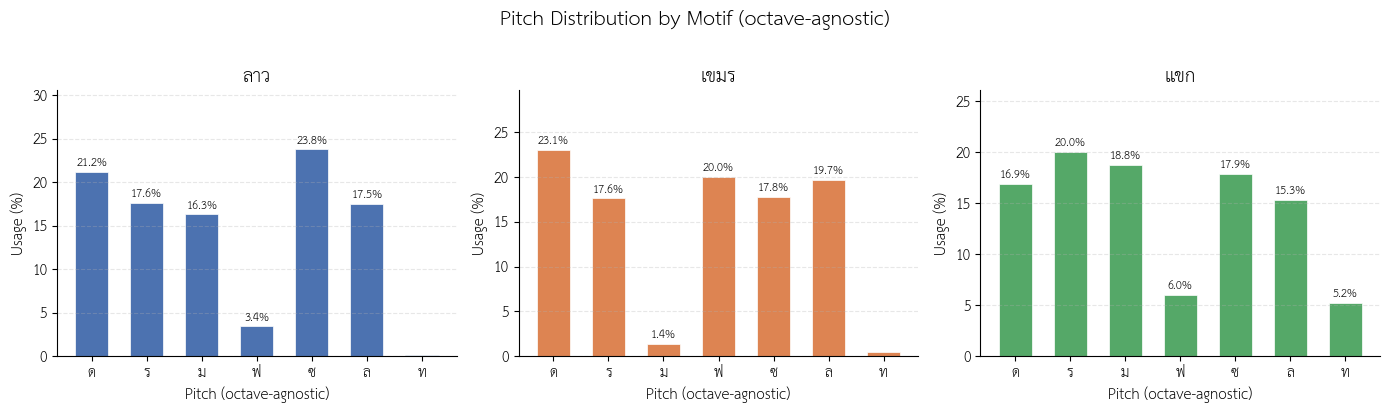

In [21]:
import matplotlib.pyplot as plt
import numpy as np

MOTIFS_SHOW  = ["ลาว", "เขมร", "แขก", ]
NOTE_ORDER   = ["ด", "ร", "ม", "ฟ", "ซ", "ล", "ท"]
MOTIF_COLORS = {"ลาว": "#4C72B0", "เขมร": "#DD8452", "แขก": "#55A868", }

fig, axes = plt.subplots(1, len(MOTIFS_SHOW), figsize=(14, 4), sharey=False)

for ax, motif in zip(axes, MOTIFS_SHOW):
    df = df_pitch_no_octave.get(motif)
    if df is None:
        ax.set_title(f"{motif} (no data)")
        continue

    # align to fixed note order
    note_pct = dict(zip(df["note"], df["percent"]))
    values   = [note_pct.get(n, 0) for n in NOTE_ORDER]

    bars = ax.bar(NOTE_ORDER, values, color=MOTIF_COLORS[motif],
                  edgecolor="white", linewidth=0.5, width=0.6)

    # value labels
    for bar, val in zip(bars, values):
        if val > 0.5:
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.3,
                    f"{val:.1f}%", ha="center", va="bottom", fontsize=8)

    ax.set_title(motif, fontsize=13, fontweight="bold")
    ax.set_xlabel("Pitch (octave-agnostic)")
    ax.set_ylabel("Usage (%)")
    ax.set_ylim(0, max(values) * 1.2 + 2)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("Pitch Distribution by Motif (octave-agnostic)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


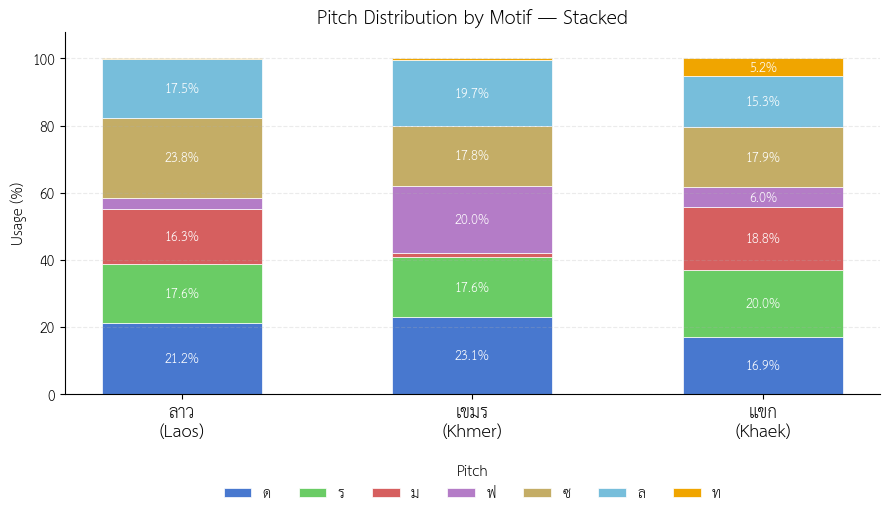

In [61]:

import matplotlib.pyplot as plt
import numpy as np

MOTIF_EN_PITCH = {"ลาว": "Laos", "เขมร": "Khmer", "แขก": "Khaek"}

# Colour per pitch note (7 pitches)
NOTE_COLORS = {
    "ด": "#4878CF", "ร": "#6ACC65", "ม": "#D65F5F",
    "ฟ": "#B47CC7", "ซ": "#C4AD66", "ล": "#77BEDB", "ท": "#F0A500",
}

fig, ax = plt.subplots(figsize=(9, 5))

x      = np.arange(len(MOTIFS_SHOW))
bottom = np.zeros(len(MOTIFS_SHOW))

for note in NOTE_ORDER:
    values = []
    for motif in MOTIFS_SHOW:
        df       = df_pitch_no_octave.get(motif)
        note_pct = dict(zip(df["note"], df["percent"])) if df is not None else {}
        values.append(note_pct.get(note, 0))

    bars = ax.bar(x, values, bottom=bottom,
                  label=note, color=NOTE_COLORS[note],
                  width=0.55, edgecolor="white", linewidth=0.5)

    for i, (v, b) in enumerate(zip(values, bottom)):
        if v > 4:                               # only label if segment is wide enough
            ax.text(x[i], b + v / 2, f"{v:.1f}%",
                    ha="center", va="center", fontsize=9,
                    color="white", fontweight="bold")

    bottom += np.array(values)

xlabels = [f"{m}\n({MOTIF_EN_PITCH.get(m, m)})" for m in MOTIFS_SHOW]
ax.set_xticks(x)
ax.set_xticklabels(xlabels, fontsize=12)
ax.set_ylabel("Usage (%)")
ax.set_ylim(0, 108)
ax.set_title("Pitch Distribution by Motif — Stacked", fontsize=13)
ax.legend(title="Pitch", loc="upper center",
          bbox_to_anchor=(0.5, -0.16), ncol=7, frameon=False, fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.20)
plt.show()


### 3.1.2 Interval Distribution


In [14]:
PITCH_ORDER = {
    "ซฺ": -3, "ลฺ": -2, "ทฺ": -1,
    "ด": 0, "ร": 1, "ม": 2, "ฟ": 3, "ซ": 4, "ล": 5, "ท": 6,
    "ดํ": 7, "รํ": 8, "มํ": 9, "ฟํ": 10, "ซํ": 11, "ลํ": 12,
}

In [15]:
def interval_bins(intervals):
    bins = {
        "Down step (-1)": 0,
        "Same (0)": 0,
        "Up step (+1)": 0,
        "Medium jump (2–3)": 0,
        "Large leap (≥4)": 0
    }

    for iv in intervals:
        if iv == -1:
            bins["Down step (-1)"] += 1
        elif iv == 0:
            bins["Same (0)"] += 1
        elif iv == 1:
            bins["Up step (+1)"] += 1
        elif abs(iv) in (2, 3):
            bins["Medium jump (2–3)"] += 1
        elif abs(iv) >= 4:
            bins["Large leap (≥4)"] += 1

    return bins

In [16]:
def extract_intervals(sequence):
    """
    Convert a symbolic sequence into signed pitch intervals
    using the PITCH_ORDER dict.
    """
    symbols = extract_symbols(sequence)
    intervals = []

    for a, b in zip(symbols, symbols[1:]):
        if a in PITCH_ORDER and b in PITCH_ORDER:
            intervals.append(PITCH_ORDER[b] - PITCH_ORDER[a])

    return intervals

In [17]:
interval_bin_pct_by_motif = {}

for motif in {s["motif"] for s in songs}:
    all_intervals = []
    for s in songs:
        if s["motif"] == motif:
            all_intervals.extend(extract_intervals(s["sequence"]))

    bins = interval_bins(all_intervals)
    total = sum(bins.values())

    interval_bin_pct_by_motif[motif] = {
        k: (v / total * 100 if total else 0)
        for k, v in bins.items()
    }

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grouped_vertical(interval_bin_pct_by_motif, title):

    motifs = list(interval_bin_pct_by_motif.keys())
    bins = list(next(iter(interval_bin_pct_by_motif.values())).keys())

    n_bins = len(bins)
    n_motifs = len(motifs)

    bar_width = 0.12   # 🔥 MUCH thinner
    x = np.arange(n_bins) * 1.1   # 🔥 add spacing between groups

    colors = plt.get_cmap("Set3").colors  # cleaner palette

    plt.figure(figsize=(14, 6))  # 🔥 wider figure

    for i, motif in enumerate(motifs):
        values = [interval_bin_pct_by_motif[motif][b] for b in bins]

        plt.bar(
            x + i * bar_width,
            values,
            width=bar_width,
            label=motif,
            color=colors[i],
            edgecolor="black",
            linewidth=0.4
        )

    plt.xticks(
        x + bar_width * (n_motifs - 1) / 2,
        bins,
        rotation=30
    )

    plt.ylabel("Percentage (%)")
    plt.title(title)
    plt.legend(frameon=False)
    plt.grid(axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()

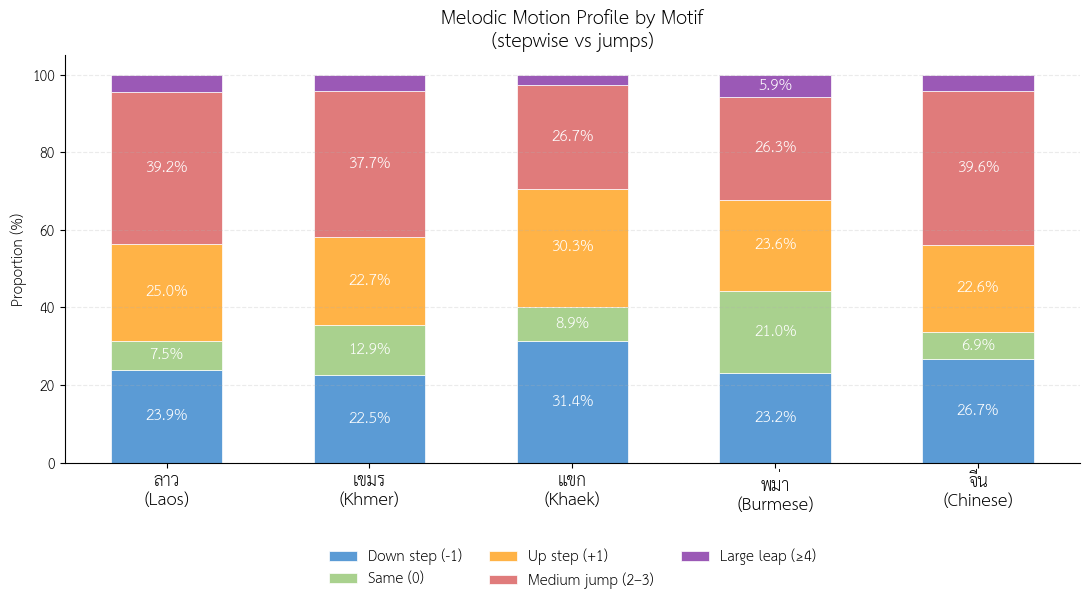

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

MOTIF_EN = {"ลาว": "Laos", "เขมร": "Khmer", "แขก": "Khaek", "พม่า": "Burmese", "จีน": "Chinese"}
MOTIFS_SHOW = ["ลาว", "เขมร", "แขก", "พม่า", "จีน"]
SEGMENT_COLORS = {
    "Down step (-1)":     "#5B9BD5",
    "Same (0)":           "#A9D18E",
    "Up step (+1)":       "#FFB347",
    "Medium jump (2–3)":  "#E07B7B",
    "Large leap (≥4)":    "#9B59B6",
}

bins_order = list(SEGMENT_COLORS.keys())

# ── filter to motifs present in data ──
available = [m for m in MOTIFS_SHOW if m in interval_bin_pct_by_motif]

fig, ax = plt.subplots(figsize=(11, 6))

x       = np.arange(len(available))
bottoms = np.zeros(len(available))

for bin_name in bins_order:
    values = [interval_bin_pct_by_motif[m].get(bin_name, 0) for m in available]
    ax.bar(x, values, bottom=bottoms, color=SEGMENT_COLORS[bin_name],
           label=bin_name, width=0.55, edgecolor="white", linewidth=0.5)
    # label segments > 5%
    for i, (v, b) in enumerate(zip(values, bottoms)):
        if v > 5:
            ax.text(x[i], b + v / 2, f"{v:.1f}%",
                    ha="center", va="center", fontsize=11, color="white", fontweight="bold")
    bottoms += np.array(values)

# x-tick labels with English translations
labels = [f"{m}\n({MOTIF_EN.get(m, m)})" for m in available]
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)

ax.set_ylabel("Proportion (%)")
ax.set_ylim(0, 105)
ax.set_title("Melodic Motion Profile by Motif\n(stepwise vs jumps)", fontsize=13)

# Legend placed outside below the chart
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=3,
    frameon=False,
    fontsize=10
)

ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)
plt.show()


In [20]:
import pandas as pd

rows = []

for motif, pct_bins in interval_bin_pct_by_motif.items():
    rows.append({
        "motif": motif,
        "stepwise_%": (
            pct_bins["Down step (-1)"]
            + pct_bins["Same (0)"]
            + pct_bins["Up step (+1)"]
        ),
        "medium_%": pct_bins["Medium jump (2–3)"],
        "large_%": pct_bins["Large leap (≥4)"],
    })

df_interval_bins = (
    pd.DataFrame(rows)
    .sort_values("motif")
    .reset_index(drop=True)
)

df_interval_bins = df_interval_bins.round(2)

df_interval_bins

,motif,stepwise_%,medium_%,large_%
0,จีน,56.18,39.56,4.26
1,พม่า,67.81,26.32,5.87
2,ลาว,56.30,39.16,4.53
3,เขมร,58.13,37.75,4.12
4,แขก,70.58,26.70,2.72
5,ไทยเดิม,55.75,31.97,12.28


## 3.2 N-grams


### 3.2.1 Symbol sequence construction
- We take each song and turn it into one linear sequence of symbols that n-grams can operate on.

- Future work may incorporate rest-aware segmentation, where extended rests are treated as phrase boundaries rather than melodic tokens.


In [23]:
def song_to_symbol_sequence(song, strip_octave=True):
    """
    Convert a song dict into a flat sequence of note symbols.
    """
    sequence = song["sequence"]  # already flattened bars
    symbols = extract_symbols(sequence, strip_octave=strip_octave)
    return symbols

In [24]:
s = songs[0]
seq = song_to_symbol_sequence(s)
seq[:30]

['ด',
 'ร',
 'ฟ',
 'ซ',
 'ฟ',
 'ฟ',
 'ล',
 'ซ',
 'ฟ',
 'ร',
 'ฟ',
 'ซ',
 'ฟ',
 'ฟ',
 'ล',
 'ด',
 'ร',
 'ด',
 'ร',
 'ฟ',
 'ซ',
 'ล',
 'ซ',
 'ฟ',
 'ร',
 'ฟ',
 'ซ',
 'ฟ',
 'ด',
 'ฟ']

In [25]:
for s in songs:
    s["symbol_sequence"] = song_to_symbol_sequence(s)

In [26]:
songs[0]["motif"], len(songs[0]["symbol_sequence"])

('เขมร', 1378)

### 3.2.2 Unigram Statistics (same as hist above)

- probably the same as histogram above

- This provides a baseline representation of melodic vocabulary and serves as a consistency check before moving to higher-order n-grams.


### 3.2.3 Bigram Statistics

- Bigram statistics count the frequency of consecutive pairs of note symbols in the symbolic sequence.

- This captures local melodic transition patterns and provides insight into motif-specific note-to-note grammar beyond individual pitch usage.


In [28]:
from collections import Counter

def extract_bigrams(symbol_sequence):
    """
    Convert a symbol sequence into bigrams.
    Example: ['ด','ร','ม'] -> [('ด','ร'), ('ร','ม')]
    """
    return zip(symbol_sequence, symbol_sequence[1:])

In [29]:
bigram_counts_by_motif = {}

for motif in {s["motif"] for s in songs}:
    counter = Counter()

    for s in songs:
        if s["motif"] == motif:
            counter.update(extract_bigrams(s["symbol_sequence"]))

    bigram_counts_by_motif[motif] = counter

In [30]:
import pandas as pd

df_bigram_by_motif = {}

for motif, counter in bigram_counts_by_motif.items():
    total = sum(counter.values())

    df = (
        pd.DataFrame([
            {
                "bigram": f"{a}→{b}",
                "count": cnt,
                "percent": cnt / total * 100
            }
            for (a, b), cnt in counter.items()
        ])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

    df_bigram_by_motif[motif] = df

In [31]:
def merge_topk_side_by_side(df_bigram_by_motif, top_k=15):

    merged = pd.DataFrame()

    for motif, df in df_bigram_by_motif.items():
        top = df.head(top_k).copy()
        top = top[["bigram", "percent"]]

        # round to 2 decimal places
        top["percent"] = top["percent"].round(2)

        top.columns = [
            f"{motif}_bigram",
            f"{motif}_%"
        ]

        merged = pd.concat([merged, top], axis=1)

    return merged


merged_df = merge_topk_side_by_side(df_bigram_by_motif, top_k=15)
merged_df

,ไทยเดิม_bigram,ไทยเดิม_%,แขก_bigram,แขก_%,เขมร_bigram,เขมร_%,ลาว_bigram,ลาว_%,จีน_bigram,จีน_%,พม่า_bigram,พม่า_%
0,ม→ร,7.54,ม→ร,8.52,ด→ร,7.98,ซ→ล,9.52,ม→ร,8.93,ม→ม,7.73
1,ล→ซ,7.54,ร→ม,7.50,ล→ด,7.83,ล→ซ,7.87,ร→ม,8.52,ซ→ล,7.73
2,ซ→ล,7.42,ร→ด,7.13,ล→ซ,7.53,ม→ซ,7.85,ซ→ล,8.44,ล→ซ,6.44
3,ม→ซ,6.78,ซ→ล,6.94,ซ→ฟ,7.43,ล→ด,7.72,ม→ซ,8.03,ล→ล,5.72
4,ร→ม,6.78,ด→ร,6.72,ร→ด,7.43,ร→ด,7.51,ล→ซ,7.53,ร→ด,5.58
5,ซ→ม,6.65,ล→ซ,6.53,ซ→ล,7.31,ด→ร,7.43,ร→ด,7.13,ด→ด,5.44
6,ร→ด,5.12,ซ→ม,4.45,ด→ล,6.78,ร→ม,6.93,ล→ด,7.04,ด→ร,4.86
7,ด→ร,4.86,ม→ซ,4.13,ฟ→ร,6.31,ม→ร,6.74,ซ→ม,6.39,ท→ล,4.58
8,ล→ด,3.96,ด→ล,3.18,ฟ→ซ,6.03,ซ→ม,6.41,ด→ร,6.14,ม→ร,4.29
9,ท→ล,3.58,ซ→ฟ,3.18,ร→ฟ,5.68,ด→ล,6.14,ด→ล,4.75,ร→ม,4.15


/var/folders/ns/3kxdm2j954q34sf6464cfn700000gn/T/ipykernel_2999/2046275788.py:32: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) TH Sarabun New.
  plt.tight_layout()
/Users/thanakrit/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) TH Sarabun New.
  fig.canvas.print_figure(bytes_io, **kw)


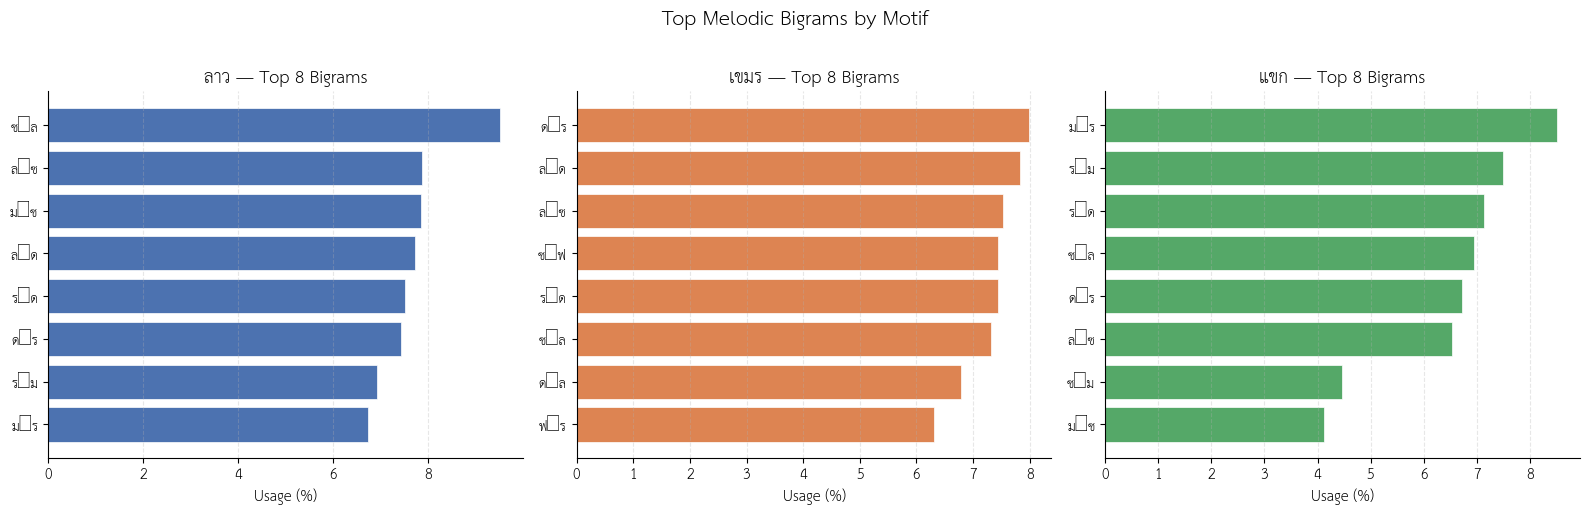

In [32]:
import matplotlib.pyplot as plt
import numpy as np

MOTIFS_SHOW  = ["ลาว", "เขมร", "แขก"]
TOP_K_PLOT   = 8
MOTIF_COLORS = {"ลาว": "#4C72B0", "เขมร": "#DD8452", "แขก": "#55A868"}

fig, axes = plt.subplots(1, len(MOTIFS_SHOW), figsize=(16, 5), sharey=False)

for ax, motif in zip(axes, MOTIFS_SHOW):
    if motif not in df_bigram_by_motif:
        ax.set_title(f"{motif} (no data)")
        continue

    top = df_bigram_by_motif[motif].head(TOP_K_PLOT)
    y   = np.arange(len(top))

    ax.barh(y, top["percent"], color=MOTIF_COLORS[motif],
            edgecolor="white", linewidth=0.5)

    ax.set_yticks(y)
    ax.set_yticklabels(top["bigram"], fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel("Usage (%)")
    ax.set_title(f"{motif} — Top {TOP_K_PLOT} Bigrams",
                 fontsize=12, fontweight="bold")
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("Top Melodic Bigrams by Motif", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


### 3.2.4 Trigram Statistics

- Trigram statistics count the frequency of three consecutive note symbols in the symbolic sequence.

- Trigrams capture short melodic phrases and local contour patterns, which are often more distinctive of motif style than single notes or pairwise transitions.


In [33]:
from collections import Counter

def extract_trigrams(symbol_sequence):
    """
    Convert a symbol sequence into trigrams.
    Example: ['ด','ร','ม','ซ'] -> [('ด','ร','ม'), ('ร','ม','ซ')]
    """
    return zip(symbol_sequence, symbol_sequence[1:], symbol_sequence[2:])

In [34]:
trigram_counts_by_motif = {}

for motif in {s["motif"] for s in songs}:
    counter = Counter()

    for s in songs:
        if s["motif"] == motif:
            counter.update(extract_trigrams(s["symbol_sequence"]))

    trigram_counts_by_motif[motif] = counter

In [35]:
import pandas as pd

df_trigram_by_motif = {}

for motif, counter in trigram_counts_by_motif.items():
    total = sum(counter.values())

    df = (
        pd.DataFrame([
            {
                "trigram": f"{a}→{b}→{c}",
                "count": cnt,
                "percent": cnt / total * 100
            }
            for (a, b, c), cnt in counter.items()
        ])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

    df_trigram_by_motif[motif] = df

In [36]:
def merge_topk_trigram_side_by_side(df_trigram_by_motif, top_k=15):

    merged = pd.DataFrame()

    for motif, df in df_trigram_by_motif.items():
        top = df.head(top_k).copy()
        top = top[["trigram", "percent"]]

        # round to 2 decimals
        top["percent"] = top["percent"].round(2)

        top.columns = [
            f"{motif}_trigram",
            f"{motif}_%"
        ]

        merged = pd.concat([merged, top], axis=1)

    return merged


merged_trigram_df = merge_topk_trigram_side_by_side(df_trigram_by_motif, top_k=15)
merged_trigram_df

,ไทยเดิม_trigram,ไทยเดิม_%,แขก_trigram,แขก_%,เขมร_trigram,เขมร_%,ลาว_trigram,ลาว_%,จีน_trigram,จีน_%,พม่า_trigram,พม่า_%
0,ล→ซ→ม,3.97,ม→ร→ด,4.92,ล→ซ→ฟ,5.17,ม→ร→ด,5.17,ม→ร→ด,5.75,ม→ม→ม,4.03
1,ซ→ม→ซ,3.33,ด→ร→ม,4.01,ฟ→ซ→ล,3.85,ซ→ล→ด,4.82,ซ→ล→ด,4.68,ล→ซ→ล,3.60
2,ม→ซ→ล,3.08,ร→ด→ร,2.88,ด→ร→ฟ,3.57,ด→ร→ม,4.46,ร→ม→ซ,4.27,ล→ล→ล,2.88
3,ซ→ม→ร,2.95,ร→ม→ร,2.71,ร→ด→ล,3.57,ม→ซ→ล,4.02,ม→ซ→ล,4.19,ม→ร→ด,2.74
4,ร→ม→ซ,2.69,ซ→ล→ซ,2.56,ซ→ล→ด,3.53,ล→ซ→ม,3.96,ด→ร→ม,4.19,ท→ล→ล,2.31
5,ร→ม→ร,2.69,ด→ล→ซ,2.30,ล→ด→ร,3.26,ซ→ล→ซ,3.81,ซ→ล→ซ,3.70,ด→ด→ด,2.31
6,ซ→ล→ซ,2.69,ล→ซ→ฟ,2.14,ด→ร→ด,3.14,ซ→ม→ซ,3.67,ล→ซ→ม,3.62,ซ→ล→ด,2.31
7,ซ→ล→ด,2.56,ซ→ม→ร,2.12,ซ→ฟ→ร,3.10,ด→ล→ซ,3.29,ซ→ม→ร,3.45,ซ→ม→ร,2.16
8,ม→ร→ด,2.56,ม→ร→ม,2.06,ฟ→ร→ด,2.96,ร→ด→ล,3.18,ร→ด→ล,3.04,ด→ร→ม,2.02
9,ด→ร→ด,2.18,ซ→ล→ด,1.97,ด→ล→ด,2.92,ร→ม→ซ,2.97,ร→ม→ร,2.96,ด→ด→ล,2.02


### 3.2.5 Quadgram Statistics


In [37]:
from collections import Counter

def extract_quadgrams(symbol_sequence):
    """
    Convert a symbol sequence into quadgrams.
    Example: ['ด','ร','ม','ซ','ล']
    -> [('ด','ร','ม','ซ'), ('ร','ม','ซ','ล')]
    """
    return zip(
        symbol_sequence,
        symbol_sequence[1:],
        symbol_sequence[2:],
        symbol_sequence[3:]
    )

In [38]:
quadgram_counts_by_motif = {}

for motif in {s["motif"] for s in songs}:
    counter = Counter()

    for s in songs:
        if s["motif"] == motif:
            counter.update(extract_quadgrams(s["symbol_sequence"]))

    quadgram_counts_by_motif[motif] = counter

In [39]:
import pandas as pd

df_quadgram_by_motif = {}

for motif, counter in quadgram_counts_by_motif.items():
    total = sum(counter.values())

    df = (
        pd.DataFrame([
            {
                "quadgram": f"{a}→{b}→{c}→{d}",
                "count": cnt,
                "percent": cnt / total * 100
            }
            for (a, b, c, d), cnt in counter.items()
        ])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

    df_quadgram_by_motif[motif] = df

In [40]:
def merge_topk_quadgram_side_by_side(df_quadgram_by_motif, top_k=15):

    merged = pd.DataFrame()

    for motif, df in df_quadgram_by_motif.items():
        top = df.head(top_k).copy()
        top = top[["quadgram", "percent"]]

        top["percent"] = top["percent"].round(2)

        top.columns = [
            f"{motif}_quadgram",
            f"{motif}_%"
        ]

        merged = pd.concat([merged, top], axis=1)

    return merged


merged_quad_df = merge_topk_quadgram_side_by_side(df_quadgram_by_motif, top_k=15)
merged_quad_df

,ไทยเดิม_quadgram,ไทยเดิม_%,แขก_quadgram,แขก_%,เขมร_quadgram,เขมร_%,ลาว_quadgram,ลาว_%,จีน_quadgram,จีน_%,พม่า_quadgram,พม่า_%
0,ล→ซ→ม→ซ,2.44,ม→ร→ด→ร,2.30,ล→ซ→ฟ→ร,2.29,ล→ซ→ม→ซ,2.78,ม→ร→ด→ล,2.56,ท→ล→ล→ล,2.32
1,ซ→ล→ซ→ม,1.54,ร→ด→ร→ม,1.65,ด→ล→ซ→ฟ,2.02,ร→ม→ร→ด,2.46,ซ→ม→ร→ด,2.31,ล→ล→ซ→ล,1.89
2,ม→ซ→ร→ม,1.41,ซ→ม→ร→ด,1.48,ร→ด→ล→ด,1.96,ม→ซ→ล→ด,2.40,ร→ม→ซ→ล,2.14,ล→ล→ล→ซ,1.89
3,ด→ล→ซ→ม,1.41,ร→ม→ร→ด,1.41,ฟ→ซ→ล→ซ,1.92,ด→ล→ซ→ม,2.17,ม→ซ→ล→ด,2.14,ม→ม→ม→ซ,1.89
4,ม→ซ→ล→ด,1.41,ด→ร→ม→ร,1.39,ด→ร→ฟ→ซ,1.82,ด→ร→ม→ร,2.04,ล→ซ→ม→ซ,2.06,ล→ซ→ล→ด,1.74
5,ล→ซ→ม→ร,1.29,ร→ม→ซ→ล,1.15,ซ→ล→ด→ร,1.68,ซ→ม→ซ→ล,2.00,ม→ซ→ล→ซ,2.06,ล→ด→ด→ล,1.74
6,ซ→ม→ร→ด,1.29,ด→ม→ร→ด,1.13,ฟ→ร→ด→ล,1.60,ร→ด→ล→ด,1.87,ด→ร→ม→ซ,1.90,ซ→ม→ร→ด,1.45
7,ด→ร→ม→ร,1.29,ซ→ฟ→ม→ร,1.06,ล→ด→ร→ด,1.54,ม→ร→ด→ล,1.85,ซ→ล→ซ→ม,1.73,ร→ม→ม→ม,1.45
8,ม→ซ→ล→ซ,1.29,ล→ด→ล→ซ,1.04,ด→ร→ด→ล,1.48,ซ→ล→ด→ร,1.68,ล→ซ→ล→ด,1.65,ด→ล→ซ→ล,1.45
9,ร→ท→ล→ซ,1.29,ร→ม→ฟ→ซ,1.02,ซ→ล→ซ→ฟ,1.42,ซ→ม→ร→ด,1.66,ร→ด→ล→ซ,1.65,ซ→ล→ท→ล,1.45


## 4. Feature vector building for Motifs cleaned

Each motif is represented by a fixed-dimensional feature vector 𝒛 that summarizes its symbolic melodic characteristics.

- The first part of 𝒛 encodes the octave-agnostic pitch distribution (ด, ร, ม, ฟ, ซ, ล, ท), capturing melodic vocabulary preferences.
- The second part of 𝒛 encodes interval magnitude statistics (stepwise, medium, large), capturing characteristic melodic motion patterns.

This compact representation enables direct quantitative comparison between motifs using standard similarity measures.


	1.	Base 7D (notes) + Directional interval stats (up / down / same)  → +3D
	2.	Interval entropy → +1D
	3.	Pitch-class entropy → +1D
	4.	Top-K pitch bigram frequencies → +K D (we’ll keep K small, e.g. 5–10)


### Helpers for Vectors


In [41]:
# ===== Pitch definitions =====
PITCH_ORDER = ["ด", "ร", "ม", "ฟ", "ซ", "ล", "ท"]

PITCH_TO_INT = {
    "ด": 0, "ร": 1, "ม": 2, "ฟ": 3, "ซ": 4, "ล": 5, "ท": 6,
}

# ===== Symbol helpers =====
from collections import Counter
import numpy as np


# Pitch statistics
def pitch_vector_from_symbols(symbols):
    counter = Counter(symbols)
    total = sum(counter.values())

    return [
        counter.get(n, 0) / total * 100 if total else 0
        for n in PITCH_ORDER
    ]

#Interval statistics (magnitude)
def interval_vector_from_symbols(symbols):
    intervals = []

    for a, b in zip(symbols, symbols[1:]):
        if a in PITCH_TO_INT and b in PITCH_TO_INT:
            intervals.append(PITCH_TO_INT[b] - PITCH_TO_INT[a])

    bins = {"stepwise": 0, "medium": 0, "large": 0}

    for iv in intervals:
        a = abs(iv)
        if a <= 1:
            bins["stepwise"] += 1
        elif a <= 3:
            bins["medium"] += 1
        else:
            bins["large"] += 1

    total = sum(bins.values())
    return [
        bins["stepwise"] / total * 100 if total else 0,
        bins["medium"] / total * 100 if total else 0,
        bins["large"] / total * 100 if total else 0,
    ]

#for V2
def directional_interval_stats(symbols):
    up = down = same = 0

    for a, b in zip(symbols, symbols[1:]):
        if a not in PITCH_TO_INT or b not in PITCH_TO_INT:
            continue

        ia = PITCH_TO_INT[a]
        ib = PITCH_TO_INT[b]

        if ib > ia:
            up += 1
        elif ib < ia:
            down += 1
        else:
            same += 1

    total = up + down + same
    if total == 0:
        return [0.0, 0.0, 0.0]

    return [
        up / total * 100,
        down / total * 100,
        same / total * 100,
    ]


#for V3
import math
from collections import Counter

def interval_entropy(symbols):
    """
    Shannon entropy of signed pitch intervals.
    """
    intervals = []
    for a, b in zip(symbols, symbols[1:]):
        if a in PITCH_TO_INT and b in PITCH_TO_INT:
            intervals.append(PITCH_TO_INT[b] - PITCH_TO_INT[a])

    if not intervals:
        return 0.0

    counter = Counter(intervals)
    total = sum(counter.values())

    entropy = 0.0
    for cnt in counter.values():
        p = cnt / total
        entropy -= p * math.log2(p)

    return entropy


# for V4
import math
from collections import Counter

def pitch_class_entropy(symbols):
    """
    Shannon entropy of pitch-class usage (octave-agnostic).
    """
    pitches = [s for s in symbols if s in PITCH_ORDER]
    if not pitches:
        return 0.0

    counter = Counter(pitches)
    total = sum(counter.values())

    entropy = 0.0
    for cnt in counter.values():
        p = cnt / total
        entropy -= p * math.log2(p)

    return entropy

#for V5
from collections import Counter

def extract_pitch_bigrams(symbols):
    """
    Extract pitch bigrams (order-sensitive, octave-agnostic).
    """
    pitches = [s for s in symbols if s in PITCH_ORDER]
    return list(zip(pitches, pitches[1:]))

def get_top_k_bigrams(songs, motifs, K=8):
    counter = Counter()

    for s in songs:
        if s["motif"] in motifs:
            bigrams = extract_pitch_bigrams(s["symbol_sequence"])
            counter.update(bigrams)

    return [bg for bg, _ in counter.most_common(K)]

### V1 (10D) BASE
  - **pitch** : dimensions 1–7 → what notes are used
  - **interval** : dimensions 8–10 → how melodies move


In [42]:
def motif_vector_v1(songs, motif):
    all_symbols = []
    for s in songs:
        if s["motif"] == motif:
            all_symbols.extend(s["symbol_sequence"])

    pitch_vec = pitch_vector_from_symbols(all_symbols)          #7D
    interval_vec = interval_vector_from_symbols(all_symbols)    #3D

    return np.array(pitch_vec + interval_vec)

In [43]:
motif_vectors_v1 = {
    motif: motif_vector_v1(songs, motif)
    for motif in {"ลาว", "เขมร", "แขก", "จีน", "พม่า"}  # filtered motifs
}

### V2 (13D)

- 7D **Pitch** (1–7): pitch-class usage (ด ร ม ฟ ซ ล ท)
- 3D **Interval** (8–10): stepwise / medium / large motion
- 3D **Direction** (11–13): up / down / same movement


In [44]:
def motif_vector_v2(songs, motif):
    base = motif_vector_v1(songs, motif)
    dir_vec = directional_interval_stats(   # +3D
        [sym for s in songs if s["motif"] == motif for sym in s["symbol_sequence"]]
    )
    return np.concatenate([base, dir_vec])

In [45]:
motif_vectors_v2 = {
    motif: motif_vector_v2(songs, motif)
    for motif in motif_vectors_v1
}

### V3 (14D)

- **Pitch** (1–7): pitch-class usage  
- **Interval** (8–10): stepwise / medium / large motion  
- **Direction** (11–13): up / down / same movement  
- **Interval entropy** (14): variability of interval usage


In [46]:
def motif_vector_v3(songs, motif):
    # base V2
    base = motif_vector_v2(songs, motif)

    # interval entropy
    all_symbols = [
        sym
        for s in songs if s["motif"] == motif
        for sym in s["symbol_sequence"]
    ]
    ent = interval_entropy(all_symbols)

    return np.concatenate([base, [ent]])


In [47]:
motif_vectors_v3 = {
    motif: motif_vector_v3(songs, motif)
    for motif in motif_vectors_v2
}

### V4 (15D)

- **Pitch** (1–7): pitch-class usage  
- **Interval** (8–10): stepwise / medium / large motion  
- **Direction** (11–13): up / down / same movement  
- **Interval entropy** (14): variability of interval usage  
- **Pitch-class entropy** (15): concentration vs spread of pitch usage


In [48]:
def motif_vector_v4(songs, motif):
    base = motif_vector_v3(songs, motif)

    all_symbols = [
        sym
        for s in songs if s["motif"] == motif
        for sym in s["symbol_sequence"]
    ]
    p_ent = pitch_class_entropy(all_symbols)

    return np.concatenate([base, [p_ent]])

In [49]:
motif_vectors_v4 = {
    motif: motif_vector_v4(songs, motif)
    for motif in motif_vectors_v3
}

### V5 (15 + K D)

- **Pitch** (1–7): pitch-class usage  
- **Interval** (8–10): stepwise / medium / large motion  
- **Direction** (11–13): up / down / same movement  
- **Interval entropy** (14): variability of interval usage  
- **Pitch-class entropy** (15): concentration of pitch usage  
- **Top-K pitch bigrams** (16–15+K): characteristic pitch transitions


In [50]:
MOTIFS_USED = list(motif_vectors_v4.keys())
TOP_K = 25

TOP_K_BIGRAMS = get_top_k_bigrams(songs, MOTIFS_USED, K=TOP_K)
TOP_K_BIGRAMS

[('ซ', 'ล'),
 ('ล', 'ซ'),
 ('ร', 'ด'),
 ('ด', 'ร'),
 ('ล', 'ด'),
 ('ม', 'ร'),
 ('ด', 'ล'),
 ('ร', 'ม'),
 ('ม', 'ซ'),
 ('ซ', 'ฟ'),
 ('ซ', 'ม'),
 ('ฟ', 'ซ'),
 ('ด', 'ด'),
 ('ฟ', 'ร'),
 ('ด', 'ซ'),
 ('ร', 'ฟ'),
 ('ล', 'ล'),
 ('ซ', 'ด'),
 ('ร', 'ร'),
 ('ซ', 'ซ'),
 ('ม', 'ม'),
 ('ฟ', 'ฟ'),
 ('ด', 'ม'),
 ('ร', 'ซ'),
 ('ล', 'ท')]

In [51]:
def bigram_vector_from_symbols(symbols, top_k_bigrams):
    bigrams = extract_pitch_bigrams(symbols)
    counter = Counter(bigrams)
    total = sum(counter.values())

    return [
        counter.get(bg, 0) / total * 100 if total else 0
        for bg in top_k_bigrams
    ]

In [52]:
def motif_vector_v5(songs, motif, top_k_bigrams):
    base = motif_vector_v4(songs, motif)

    all_symbols = [
        sym
        for s in songs if s["motif"] == motif
        for sym in s["symbol_sequence"]
    ]

    bg_vec = bigram_vector_from_symbols(all_symbols, top_k_bigrams)

    return np.concatenate([base, bg_vec])

In [53]:
motif_vectors_v5 = {
    motif: motif_vector_v5(songs, motif, TOP_K_BIGRAMS)
    for motif in motif_vectors_v4
}

### Cosine Sim V1 to V5 motifs to motifs (only V2 and V5)


In [54]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# ===== Motif-level cosine similarity (V2) =====

motifs = list(motif_vectors_v2.keys())
X = np.vstack([motif_vectors_v2[m] for m in motifs])

sim_matrix = cosine_similarity(X)

df_similarity_v2 = pd.DataFrame(
    sim_matrix,
    index=motifs,
    columns=motifs
)

df_similarity_v2

,แขก,เขมร,ลาว,จีน,พม่า
แขก,1.000000,0.966802,0.987926,0.989260,0.983424
เขมร,0.966802,1.000000,0.971351,0.962806,0.961352
ลาว,0.987926,0.971351,1.000000,0.998354,0.971616
จีน,0.989260,0.962806,0.998354,1.000000,0.971189
พม่า,0.983424,0.961352,0.971616,0.971189,1.000000


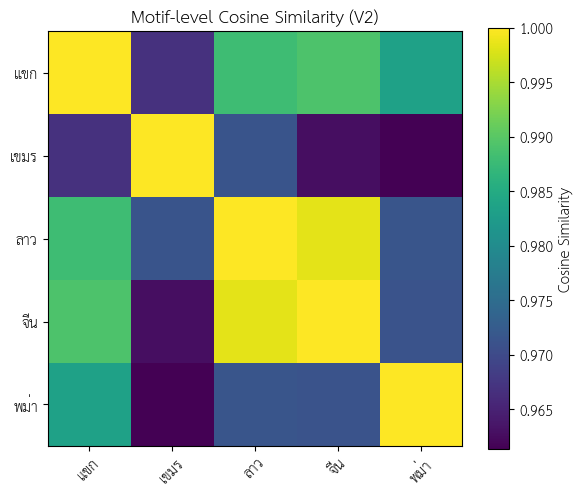

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(df_similarity_v2.values, cmap="viridis")
plt.colorbar(label="Cosine Similarity")

plt.xticks(range(len(motifs)), motifs, rotation=45)
plt.yticks(range(len(motifs)), motifs)

plt.title("Motif-level Cosine Similarity (V2)")
plt.tight_layout()
plt.show()

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# ===== Motif-level cosine similarity (V2) =====

motifs = list(motif_vectors_v5.keys())
X = np.vstack([motif_vectors_v5[m] for m in motifs])

sim_matrix = cosine_similarity(X)

df_similarity_v5 = pd.DataFrame(
    sim_matrix,
    index=motifs,
    columns=motifs
)

df_similarity_v5

,แขก,เขมร,ลาว,จีน,พม่า
แขก,1.000000,0.954144,0.984388,0.986167,0.978937
เขมร,0.954144,1.000000,0.958799,0.945549,0.950234
ลาว,0.984388,0.958799,1.000000,0.997486,0.964372
จีน,0.986167,0.945549,0.997486,1.000000,0.963322
พม่า,0.978937,0.950234,0.964372,0.963322,1.000000


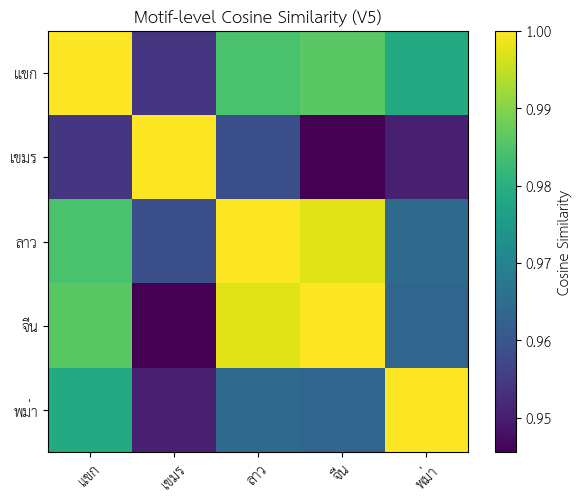

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(df_similarity_v5.values, cmap="viridis")
plt.colorbar(label="Cosine Similarity")

plt.xticks(range(len(motifs)), motifs, rotation=45)
plt.yticks(range(len(motifs)), motifs)

plt.title("Motif-level Cosine Similarity (V5)")
plt.tight_layout()
plt.show()

### PCA — Motif Feature Space (Song-level)

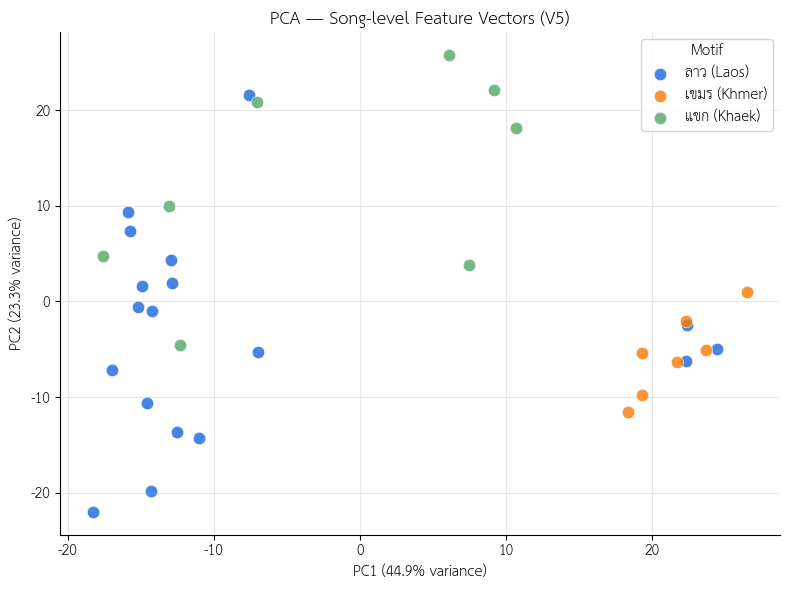

Total variance explained: 68.2%


In [60]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

MOTIFS_PCA = ["ลาว", "เขมร", "แขก"]
MOTIF_EN   = {"ลาว": "Laos", "เขมร": "Khmer", "แขก": "Khaek", "พม่า": "Burmese", "จีน": "Chinese"}
COLORS     = {"ลาว": "#1A65DE", "เขมร": "#FA7A03", "แขก": "#55A868"}

# ── Per-song V5 vector ──────────────────────────────────────────────────────
def song_vector_v5(symbols, top_k_bigrams):
    """Build a V5 feature vector for a single song's symbol sequence."""
    pitch_vec    = pitch_vector_from_symbols(symbols)        # 7D
    interval_vec = interval_vector_from_symbols(symbols)     # 3D
    dir_vec      = directional_interval_stats(symbols)       # 3D
    ent          = interval_entropy(symbols)                 # 1D
    p_ent        = pitch_class_entropy(symbols)              # 1D
    bg_vec       = bigram_vector_from_symbols(symbols, top_k_bigrams)  # K D
    return np.concatenate([pitch_vec, interval_vec, dir_vec, [ent], [p_ent], bg_vec])

# ── Build song-level matrix ─────────────────────────────────────────────────
X_pca, y_pca, song_names = [], [], []
for s in songs:
    if s["motif"] not in MOTIFS_PCA:
        continue
    vec = song_vector_v5(s["symbol_sequence"], TOP_K_BIGRAMS)
    X_pca.append(vec)
    y_pca.append(s["motif"])
    song_names.append(s["song"])

X_pca = np.vstack(X_pca)

# ── Fit PCA (2 components) ──────────────────────────────────────────────────
pca  = PCA(n_components=2)
X_2d = pca.fit_transform(X_pca)
explained = pca.explained_variance_ratio_ * 100

# ── Plot ────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

for motif in MOTIFS_PCA:
    idx   = [i for i, m in enumerate(y_pca) if m == motif]
    label = f"{motif} ({MOTIF_EN.get(motif, motif)})"
    ax.scatter(
        X_2d[idx, 0], X_2d[idx, 1],
        label=label,
        color=COLORS[motif],
        s=80, alpha=0.8, edgecolors="white", linewidths=0.5
    )

ax.set_xlabel(f"PC1 ({explained[0]:.1f}% variance)")
ax.set_ylabel(f"PC2 ({explained[1]:.1f}% variance)")
ax.set_title("PCA — Song-level Feature Vectors (V5)")
ax.legend(title="Motif", frameon=True)
ax.grid(alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

print(f"Total variance explained: {sum(explained):.1f}%")


### Fragment Vectorization (for testing)


In [62]:
def get_fragment_symbols(song, n_symbols=16):
    return song["symbol_sequence"][:n_symbols]

def fragment_vector_v1(symbols):
    return np.array(
        pitch_vector_from_symbols(symbols)
        + interval_vector_from_symbols(symbols)
    )

def fragment_vector_v2(symbols):
    return np.concatenate([
        fragment_vector_v1(symbols),
        directional_interval_stats(symbols)
    ])

def fragment_vector_v3(symbols):
    base = fragment_vector_v2(symbols)
    ent = interval_entropy(symbols)
    return np.concatenate([base, [ent]])

def fragment_vector_v4(symbols):
    base = fragment_vector_v3(symbols)
    p_ent = pitch_class_entropy(symbols)
    return np.concatenate([base, [p_ent]])

def fragment_vector_v5(symbols, top_k_bigrams):
    base = fragment_vector_v4(symbols)
    bg_vec = bigram_vector_from_symbols(symbols, top_k_bigrams)
    return np.concatenate([base, bg_vec])

### Cosine Similarity demo with fragment






In [63]:
from sklearn.metrics.pairwise import cosine_similarity

def rank_fragment(fragment_vec, motif_vectors):
    return sorted(
        {
            motif: cosine_similarity(
                fragment_vec.reshape(1, -1),
                vec.reshape(1, -1)
            )[0, 0]
            for motif, vec in motif_vectors.items()
        }.items(),
        key=lambda x: x[1],
        reverse=True
    )

In [124]:
raw_frag = [ "--ดํล", "ดํลรํดํ", "--ฟร", "ฟรซฟ", "--ดํล", "--รํดํ", "ฟรซฟ", "ลซดํล" ] #khmer เขมร
frag = extract_symbols(raw_frag, strip_octave=True)

In [125]:
raw_frag = [ "ดํรํดํล", "ดํซลดํ", "ดํรํดํล", "ดํลซฟ", "----", "ดรฟซ", "ลฟลซ", "-ฟ-ร" ] #khmer เขมร
frag = extract_symbols(raw_frag, strip_octave=True)


In [126]:
raw_frag = [ "----", "----", "-ซ-ล", "-ท-ดํ", "---ท", "--ดํรํ", "มํรํดํท", "ดํรํ-ดํ" ] #แขก
frag = extract_symbols(raw_frag, strip_octave=True)

In [127]:
raw_frag = ["-รซล", "ทดํรํ", "--ดํมํ", "รํดํทล", "ทลซดํ", "-ท-ล", "ทลซล", "ซฟมฟ" ] 
frag = extract_symbols(raw_frag, strip_octave=True)

In [128]:
raw_frag = [ "----", "----", "--ซล", "ดํมรด", "รม-ซ", "-ล--", "ดํลซม", "ซล-ดํ","รํมํรํดํ" ] #ลาว correct
frag = extract_symbols(raw_frag, strip_octave=True)

In [129]:
raw_frag = [
          "----",
          "รมซล",
          "ซลดํล",
          "-ซซซ",
          "-ดรม",
          "-ซ-ล",
          "-ดํ-มํ",
          "-รํมํซํ"
        ] #ลาว  correct
frag = extract_symbols(raw_frag, strip_octave=True)

In [130]:
raw_frag =[
          "ดํลซม",
          "-ร-ด",
          "--มร",
          "ดร-ม",
          "รด-ร",
          "-ม-ซ",
          "ลซดํล",
          "ซม-ร"
        ] #ลาว expected wrong

frag = extract_symbols(raw_frag, strip_octave=True)

In [131]:
raw_frag = [
          "---ฟ",
          "--ลดํ",
          "-ดํ-รํ",
          "ดํดํดํดํ",
          "-ฟํ-ล",
          "ดํดํดํดํ",
          "-ล-รํ",
          "ดํดํดํดํ"
        ]  #ลาว expected wrong

frag = extract_symbols(raw_frag, strip_octave=True)

In [132]:
raw_frag = [
          "-มํ-รํ",
          "-ดํรํมํ",
          "--ดํรํ",
          "มํรํดํล",
          "--ดํล",
          "ซมซล",
          "-ดํรํมํ",
          "-รํ-ดํ"
        ]
frag = extract_symbols(raw_frag, strip_octave=True)

In [133]:
raw_frag = ["----","มดรม","รมฟซ","ฟซทล","-ลล-","ซฟมฟ","-ฟฟ-","มรดร"]
frag = extract_symbols(raw_frag, strip_octave=True)

In [64]:
raw_frag = [ "-รซล", "ทดํรํ", "--ดํมํ", "รํดํทล", "ทลซดํ", "-ท-ล", "ทลซล", "ซฟมฟ" ] #khaek
frag = extract_symbols(raw_frag, strip_octave=True)

In [135]:
raw_frag = [ "----", "-มํรํดํ", "--ลซ", "มซลดํ", "-ซลซ", "ลดํ-ล", "ดํลซม", "-รมซ" ]
frag = extract_symbols(raw_frag, strip_octave=True)

In [65]:
rank_fragment(fragment_vector_v1(frag), motif_vectors_v1)


[('พม่า', 0.9716131344602846),
 ('แขก', 0.9590275733099293),
 ('เขมร', 0.9238371794975734),
 ('จีน', 0.9178547023274561),
 ('ลาว', 0.9178184245754316)]

In [66]:
rank_fragment(fragment_vector_v2(frag), motif_vectors_v2)

[('แขก', 0.9687152062217941),
 ('พม่า', 0.9543274009243888),
 ('จีน', 0.9459002060895693),
 ('ลาว', 0.9437064507112528),
 ('เขมร', 0.9421151219458974)]

In [67]:
rank_fragment(fragment_vector_v3(frag), motif_vectors_v3)

[('แขก', 0.968686293426863),
 ('พม่า', 0.9542882474592145),
 ('จีน', 0.9458677948204813),
 ('ลาว', 0.9436769731055304),
 ('เขมร', 0.9420775121640196)]

In [68]:
rank_fragment(fragment_vector_v4(frag), motif_vectors_v4)

[('แขก', 0.9687040973115719),
 ('พม่า', 0.9543144804989465),
 ('จีน', 0.9458988726594082),
 ('ลาว', 0.9437093882736376),
 ('เขมร', 0.9421106192538695)]

In [69]:
rank_fragment(fragment_vector_v5(frag, TOP_K_BIGRAMS), motif_vectors_v5)

[('แขก', 0.9575230264342638),
 ('พม่า', 0.9419614769146439),
 ('จีน', 0.9278839407952667),
 ('ลาว', 0.9258016745175434),
 ('เขมร', 0.9239627521428629)]

## X. Grouping for LSTM (skipped)

In [148]:
from collections import defaultdict

def find_pattern_occurrences(songs, motif, patterns):
    """
    Find occurrences of specific note patterns in songs of a given motif.
    
    Args:
        songs: list of song dicts with 'symbol_sequence'
        motif: motif name (e.g., 'ลาว')
        patterns: list of pattern strings (e.g., ['รดด', 'รดดด', 'ลซซ', 'ลซซซซ'])
    
    Returns:
        dict mapping pattern -> list of (song_name, count, positions)
    """
    results = defaultdict(lambda: [])
    
    for s in songs:
        if s["motif"] != motif:
            continue
        
        song_name = s["song"]
        seq_str = "".join(s["symbol_sequence"])  # Convert to string for easier pattern matching
        
        for pattern in patterns:
            count = 0
            positions = []
            start = 0
            
            # Find all non-overlapping occurrences
            while True:
                pos = seq_str.find(pattern, start)
                if pos == -1:
                    break
                count += 1
                positions.append(pos)
                start = pos + 1  # Allow overlapping matches
            
            if count > 0:
                results[pattern].append({
                    "song": song_name,
                    "count": count,
                    "positions": positions
                })
    
    return results

# Define patterns to search for (octave-agnostic)
patterns_to_find = ['รดด', 'รดดด','รดดดด', 'ลซซ', 'ลซซซ', 'ลซซซซ']

# Extract occurrences for ลาว motif
laos_patterns = find_pattern_occurrences(songs, 'ลาว', patterns_to_find)

# Display results
for pattern, occurrences in laos_patterns.items():
    print(f"\n{'='*60}")
    print(f"Pattern: {pattern}")
    print(f"{'='*60}")
    
    total_count = sum(occ["count"] for occ in occurrences)
    print(f"Total occurrences: {total_count}")
    print(f"Songs containing this pattern: {len(occurrences)}")
    print()
    
    # Create a dataframe for this pattern
    pattern_df = pd.DataFrame([
        {
            "song": occ["song"],
            "count": occ["count"]
        }
        for occ in occurrences
    ]).sort_values("count", ascending=False)
    
    print(pattern_df.to_string(index=False))


Pattern: รดด
Total occurrences: 27
Songs containing this pattern: 10

                song  count
        ลาวดวงดอกไม้      7
ลาวเสี่ยงเทียน (เถา)      7
         ลาวดวงเดือน      2
        ลาวกระตุกกี่      2
            ลาวกระแซ      2
         ลาวเจริญศรี      2
            ลาวคำหอม      2
         ลาวกระทบไม้      1
       ลาวดำเนินทราย      1
        ลาวต้อยตริ่ง      1

Pattern: ลซซ
Total occurrences: 33
Songs containing this pattern: 14

                song  count
         ลาวกระทบไม้      4
        ลาวต้อยตริ่ง      4
         ลาวเจริญศรี      4
            ลาวกระแต      3
         ลาวดวงเดือน      3
        ลาวกระแตเล็ก      3
            ลาวกระแซ      3
ลาวเสี่ยงเทียน (เถา)      2
       ลาวดำเนินทราย      2
      ลาวเสี่ยงเทียน      1
             ลาวจ้อย      1
         ลาวเล่นนํ้า      1
           ลาวสมเด็จ      1
            ลาวคำหอม      1

Pattern: ลซซซ
Total occurrences: 26
Songs containing this pattern: 13

                song  count
         ลาวเจริญศรี      4
  

## Fragment-level Motif Classification


- **Fragment**: 32 slots (1 bar), non-overlapping windows
- **Rest filter**: skip if >50% rest slots
- **Classifiers**: Cosine nearest-centroid · Logistic Regression (LOO-CV)


In [70]:
def extract_non_overlapping_fragments(
    songs,
    window_size=32,
    rest_threshold=0.5,
    strip_octave=True
):
    fragments = []

    for s in songs:
        motif   = s["motif"]
        raw_seq = s["sequence"]

        for i in range(0, len(raw_seq), window_size):
            window_tokens = raw_seq[i : i + window_size]

            if len(window_tokens) < window_size:
                continue

            rest_count = sum(1 for t in window_tokens if t == "----")
            if rest_count / window_size > rest_threshold:
                continue

            frag_symbols = extract_symbols(window_tokens, strip_octave=strip_octave)

            if len(frag_symbols) < 5:
                continue

            fragments.append((frag_symbols, motif))

    return fragments


In [74]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd

# ── Cosine nearest-centroid ──────────────────────────────────────────────────
def fragment_cosine_evaluation(fragments, motif_vectors, fragment_vector_fn, extra_args=None):
    y_true, y_pred = [], []
    for symbols, true_motif in fragments:
        x    = fragment_vector_fn(symbols, *extra_args) if extra_args else fragment_vector_fn(symbols)
        sims = {m: cosine_similarity(x.reshape(1, -1), v.reshape(1, -1))[0, 0]
                for m, v in motif_vectors.items()}
        y_true.append(true_motif)
        y_pred.append(max(sims, key=sims.get))
    labels = sorted(set(y_true))
    return (round(accuracy_score(y_true, y_pred), 4),
            pd.DataFrame(confusion_matrix(y_true, y_pred, labels=labels), index=labels, columns=labels))

# ── Logistic Regression (LOO-CV) ─────────────────────────────────────────────
def fragment_logreg_evaluation(fragments, fragment_vector_fn):
    y_true, y_pred = [], []
    for i, (test_sym, test_lbl) in enumerate(fragments):
        train   = [(s, l) for j, (s, l) in enumerate(fragments) if j != i]
        X_train = np.vstack([fragment_vector_fn(s) for s, _ in train])
        y_train = [l for _, l in train]
        # clf = LogisticRegression(solver="lbfgs", max_iter=1000)
        clf = LogisticRegression(solver="saga", max_iter=5000) #SAGA is designed for multiclass and converges faster with small, unbalanced folds
        clf.fit(X_train, y_train)
        y_true.append(test_lbl)
        y_pred.append(clf.predict(fragment_vector_fn(test_sym).reshape(1, -1))[0])
    labels = sorted(set(y_true))
    return (round(accuracy_score(y_true, y_pred), 4),
            pd.DataFrame(confusion_matrix(y_true, y_pred, labels=labels), index=labels, columns=labels))


In [72]:
MOTIFS_USED = ["ลาว", "เขมร", "แขก"]

fragments = extract_non_overlapping_fragments(songs, window_size=32, rest_threshold=0.5)
dist = {m: sum(1 for _, lbl in fragments if lbl == m) for m in MOTIFS_USED}
print(f"Fragments extracted: {len(fragments)} | {dist}")

# ── Cosine V1–V5 ──────────────────────────────────────────────────────────────
acc_v1_frag, cm_v1_frag = fragment_cosine_evaluation(fragments, motif_vectors_v1, fragment_vector_v1)
acc_v2_frag, cm_v2_frag = fragment_cosine_evaluation(fragments, motif_vectors_v2, fragment_vector_v2)
acc_v3_frag, cm_v3_frag = fragment_cosine_evaluation(fragments, motif_vectors_v3, fragment_vector_v3)
acc_v4_frag, cm_v4_frag = fragment_cosine_evaluation(fragments, motif_vectors_v4, fragment_vector_v4)
acc_v5_frag, cm_v5_frag = fragment_cosine_evaluation(fragments, motif_vectors_v5, fragment_vector_v5,
                                                      extra_args=[TOP_K_BIGRAMS])

print("Cosine:", [f"V{i+1}={a:.4f}" for i, a in
      enumerate([acc_v1_frag, acc_v2_frag, acc_v3_frag, acc_v4_frag, acc_v5_frag])])


# (0.596, 0.6162, 0.6162, 0.6162, 0.6364) Previous run



Fragments extracted: 200 | {'ลาว': 54, 'เขมร': 59, 'แขก': 54}
Cosine: ['V1=0.6100', 'V2=0.6250', 'V3=0.6250', 'V4=0.6250', 'V5=0.6500']


In [75]:
# ── LogReg LOO-CV V1–V5 ───────────────────────────────────────────────────────
acc_f_v1, cm_f_v1 = fragment_logreg_evaluation(fragments, fragment_vector_v1)
acc_f_v2, cm_f_v2 = fragment_logreg_evaluation(fragments, fragment_vector_v2)
acc_f_v3, cm_f_v3 = fragment_logreg_evaluation(fragments, fragment_vector_v3)
acc_f_v4, cm_f_v4 = fragment_logreg_evaluation(fragments, fragment_vector_v4)
acc_f_v5, cm_f_v5 = fragment_logreg_evaluation(fragments, lambda s: fragment_vector_v5(s, TOP_K_BIGRAMS))

print("LogReg:", [f"V{i+1}={a:.4f}" for i, a in
      enumerate([acc_f_v1, acc_f_v2, acc_f_v3, acc_f_v4, acc_f_v5])])


# previous lbfgs 1000 max_iter results:
(0.7071, 0.6919, 0.6869, 0.6919, 0.702)

LogReg: ['V1=0.7100', 'V2=0.6950', 'V3=0.6950', 'V4=0.6950', 'V5=0.7000']


(0.7071, 0.6919, 0.6869, 0.6919, 0.702)

/var/folders/ns/3kxdm2j954q34sf6464cfn700000gn/T/ipykernel_2999/3674174476.py:48: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) TH Sarabun New.
  plt.tight_layout()
/Users/thanakrit/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) TH Sarabun New.
  fig.canvas.print_figure(bytes_io, **kw)


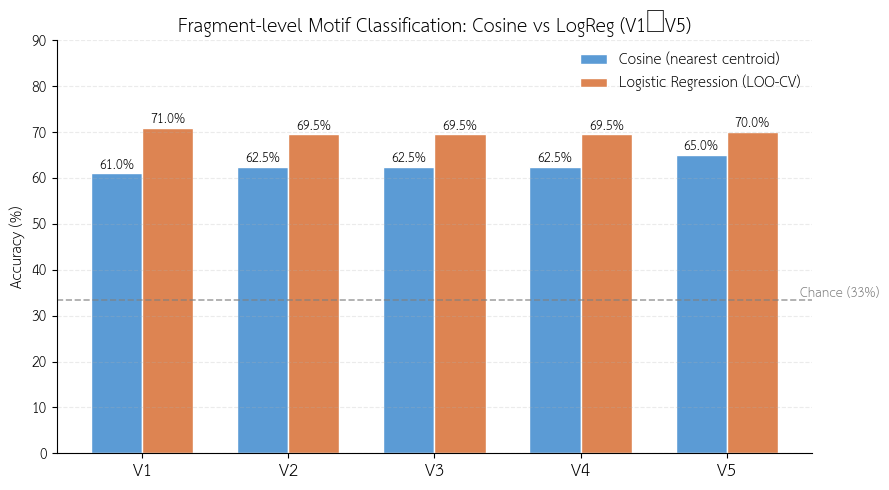

Cosine: ['V1=0.6100', 'V2=0.6250', 'V3=0.6250', 'V4=0.6250', 'V5=0.6500']
LogReg: ['V1=0.7100', 'V2=0.6950', 'V3=0.6950', 'V4=0.6950', 'V5=0.7000']


In [76]:

# ── Fragment-level V1→V5: Cosine vs LogReg accuracy bar chart ────────────────
import matplotlib.pyplot as plt
import numpy as np

MOTIF_EN_F = {"ลาว": "Laos", "เขมร": "Khmer", "แขก": "Khaek"}

versions    = ["V1", "V2", "V3", "V4", "V5"]
cosine_accs = [acc_v1_frag, acc_v2_frag, acc_v3_frag, acc_v4_frag, acc_v5_frag]
logreg_accs = [acc_f_v1,    acc_f_v2,    acc_f_v3,    acc_f_v4,    acc_f_v5]
chance      = 1 / 3   # 3-class

x     = np.arange(len(versions))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))

bars_c = ax.bar(x - width/2, [a * 100 for a in cosine_accs],
                width, label="Cosine (nearest centroid)",
                color="#5B9BD5", edgecolor="white")
bars_l = ax.bar(x + width/2, [a * 100 for a in logreg_accs],
                width, label="Logistic Regression (LOO-CV)",
                color="#DD8452", edgecolor="white")

# Value labels on bars
for bar in bars_c:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.4,
            f"{h:.1f}%", ha="center", va="bottom", fontsize=9, fontweight="bold")
for bar in bars_l:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.4,
            f"{h:.1f}%", ha="center", va="bottom", fontsize=9, fontweight="bold")

# Chance baseline
ax.axhline(chance * 100, color="gray", linestyle="--", linewidth=1.2, alpha=0.7)
ax.text(len(versions) - 0.5, chance * 100 + 0.8,
        f"Chance ({chance*100:.0f}%)", color="gray", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(versions, fontsize=12)
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 90)
ax.set_title("Fragment-level Motif Classification: Cosine vs LogReg (V1→V5)", fontsize=13)
ax.legend(frameon=False, fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

print("Cosine:", [f"V{i+1}={a:.4f}" for i, a in enumerate(cosine_accs)])
print("LogReg:", [f"V{i+1}={a:.4f}" for i, a in enumerate(logreg_accs)])


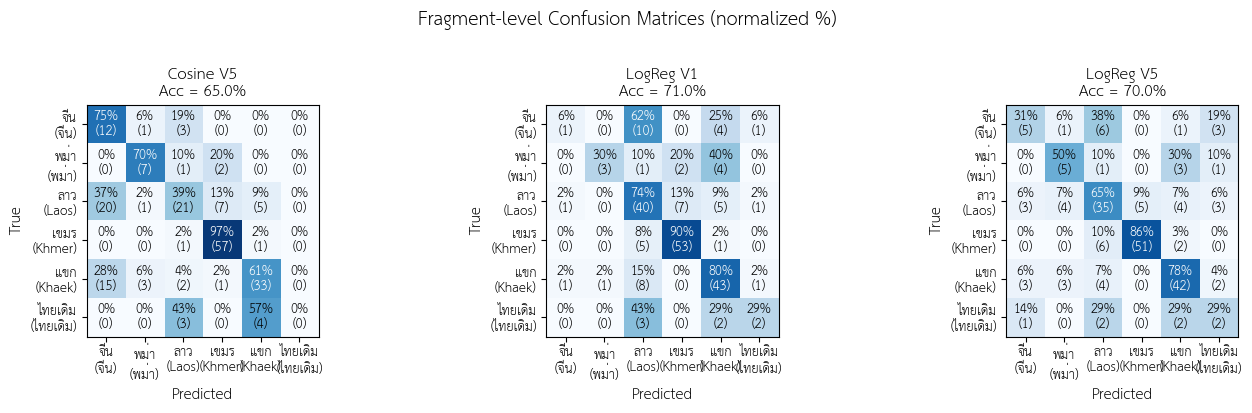

In [77]:

# ── Fragment-level Confusion Matrices: Cosine V5 | LogReg V1 | LogReg V5 ────
import matplotlib.pyplot as plt
import numpy as np

panels = [
    ("Cosine V5",    cm_v5_frag, acc_v5_frag),
    ("LogReg V1",    cm_f_v1,    acc_f_v1),
    ("LogReg V5",    cm_f_v5,    acc_f_v5),
]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (title, cm, acc) in zip(axes, panels):
    labels = list(cm.index)
    mat    = cm.values.astype(float)

    # Normalize to % per true row
    row_sums = mat.sum(axis=1, keepdims=True)
    mat_pct  = np.where(row_sums > 0, mat / row_sums * 100, 0)

    im = ax.imshow(mat_pct, cmap="Blues", vmin=0, vmax=100)

    # Cell annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            val = mat_pct[i, j]
            color = "white" if val > 60 else "black"
            ax.text(j, i, f"{val:.0f}%\n({int(mat[i,j])})",
                    ha="center", va="center", fontsize=9, color=color)

    # Bilingual tick labels
    tick_labels = [f"{l}\n({MOTIF_EN_F.get(l, l)})" for l in labels]
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(tick_labels, fontsize=9)
    ax.set_yticklabels(tick_labels, fontsize=9)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{title}\nAcc = {acc*100:.1f}%", fontsize=11, fontweight="bold")

plt.suptitle("Fragment-level Confusion Matrices (normalized %)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


## Song-level Motif Classification (LOSO)


**Protocol: Leave-One-Song-Out (LOSO)**  
Hold one song out as test, train on all remaining songs, predict the held-out song's motif. Repeat for every song.

Classifiers: Cosine nearest-centroid · Logistic Regression


In [78]:
# ── Song-level feature vectors (V1→V5) ──────────────────────────────────────
# Each function takes a single song dict and builds its vector from symbol_sequence directly.

def song_vector_v1(song):
    sym = song["symbol_sequence"]
    return np.array(pitch_vector_from_symbols(sym) + interval_vector_from_symbols(sym))

def song_vector_v2(song):
    sym = song["symbol_sequence"]
    return np.concatenate([song_vector_v1(song), directional_interval_stats(sym)])

def song_vector_v3(song):
    sym = song["symbol_sequence"]
    return np.concatenate([song_vector_v2(song), [interval_entropy(sym)]])

def song_vector_v4(song):
    sym = song["symbol_sequence"]
    return np.concatenate([song_vector_v3(song), [pitch_class_entropy(sym)]])

def song_vector_v5(song, top_k_bigrams):
    sym = song["symbol_sequence"]
    return np.concatenate([song_vector_v4(song), bigram_vector_from_symbols(sym, top_k_bigrams)])


In [80]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd

# ── Cosine nearest-centroid (LOSO) ───────────────────────────────────────────
def loso_cosine_evaluation(songs, song_vector_fn, motifs_used, extra_args=None):
    y_true, y_pred = [], []
    for i, test_song in enumerate(songs):
        if test_song["motif"] not in motifs_used:
            continue
        train = [s for j, s in enumerate(songs) if j != i and s["motif"] in motifs_used]
        centroids = {}
        for m in motifs_used:
            vecs = [song_vector_fn(s, *extra_args) if extra_args else song_vector_fn(s)
                    for s in train if s["motif"] == m]
            centroids[m] = np.mean(np.vstack(vecs), axis=0)
        x = song_vector_fn(test_song, *extra_args) if extra_args else song_vector_fn(test_song)
        sims = {m: cosine_similarity(x.reshape(1, -1), c.reshape(1, -1))[0, 0]
                for m, c in centroids.items()}
        y_true.append(test_song["motif"])
        y_pred.append(max(sims, key=sims.get))
    labels = sorted(set(y_true))
    return (round(accuracy_score(y_true, y_pred), 4),
            pd.DataFrame(confusion_matrix(y_true, y_pred, labels=labels), index=labels, columns=labels))

# ── Logistic Regression (LOSO) ────────────────────────────────────────────────
def loso_logreg_evaluation(songs, song_vector_fn, motifs_used):
    y_true, y_pred = [], []
    for i, test_song in enumerate(songs):
        if test_song["motif"] not in motifs_used:
            continue
        train   = [s for j, s in enumerate(songs) if j != i and s["motif"] in motifs_used]
        X_train = np.vstack([song_vector_fn(s) for s in train])
        y_train = [s["motif"] for s in train]
        clf = LogisticRegression(solver="saga", max_iter=5000)
        clf.fit(X_train, y_train)
        y_true.append(test_song["motif"])
        y_pred.append(clf.predict(song_vector_fn(test_song).reshape(1, -1))[0])
    labels = sorted(set(y_true))
    return (round(accuracy_score(y_true, y_pred), 4),
            pd.DataFrame(confusion_matrix(y_true, y_pred, labels=labels), index=labels, columns=labels))


In [81]:
MOTIFS_USED = ["ลาว", "เขมร", "แขก"]

# ── Cosine LOSO V1–V5 ─────────────────────────────────────────────────────────
acc_v1, cm_v1 = loso_cosine_evaluation(songs, song_vector_v1, MOTIFS_USED)
acc_v2, cm_v2 = loso_cosine_evaluation(songs, song_vector_v2, MOTIFS_USED)
acc_v3, cm_v3 = loso_cosine_evaluation(songs, song_vector_v3, MOTIFS_USED)
acc_v4, cm_v4 = loso_cosine_evaluation(songs, song_vector_v4, MOTIFS_USED)
acc_v5, cm_v5 = loso_cosine_evaluation(songs, song_vector_v5, MOTIFS_USED, extra_args=[TOP_K_BIGRAMS])

print("Cosine LOSO:", [f"V{i+1}={a:.4f}" for i, a in
      enumerate([acc_v1, acc_v2, acc_v3, acc_v4, acc_v5])])


Cosine LOSO: ['V1=0.7879', 'V2=0.7879', 'V3=0.7879', 'V4=0.7879', 'V5=0.7879']


In [82]:
cosine_accs = {"V1": acc_v1, "V2": acc_v2, "V3": acc_v3, "V4": acc_v4, "V5": acc_v5}
print("Cosine LOSO accuracies saved:", cosine_accs)


Cosine LOSO accuracies saved: {'V1': 0.7879, 'V2': 0.7879, 'V3': 0.7879, 'V4': 0.7879, 'V5': 0.7879}


In [83]:
# ── LogReg LOSO V1–V5 ─────────────────────────────────────────────────────────
acc_v1, cm_v1 = loso_logreg_evaluation(songs, song_vector_v1, MOTIFS_USED)
acc_v2, cm_v2 = loso_logreg_evaluation(songs, song_vector_v2, MOTIFS_USED)
acc_v3, cm_v3 = loso_logreg_evaluation(songs, song_vector_v3, MOTIFS_USED)
acc_v4, cm_v4 = loso_logreg_evaluation(songs, song_vector_v4, MOTIFS_USED)
acc_v5, cm_v5 = loso_logreg_evaluation(songs, lambda s: song_vector_v5(s, TOP_K_BIGRAMS), MOTIFS_USED)

print("LogReg LOSO:", [f"V{i+1}={a:.4f}" for i, a in
      enumerate([acc_v1, acc_v2, acc_v3, acc_v4, acc_v5])])


LogReg LOSO: ['V1=0.8182', 'V2=0.7879', 'V3=0.7879', 'V4=0.7879', 'V5=0.7879']


In [84]:
import pandas as pd

df_song_acc = pd.DataFrame({
    "Version": ["V1", "V2", "V3", "V4", "V5"],
    "Cosine":  [cosine_accs[v] for v in ["V1", "V2", "V3", "V4", "V5"]],
    "LogReg":  [acc_v1, acc_v2, acc_v3, acc_v4, acc_v5],
})
df_song_acc


,Version,Cosine,LogReg
0,V1,0.7879,0.8182
1,V2,0.7879,0.7879
2,V3,0.7879,0.7879
3,V4,0.7879,0.7879
4,V5,0.7879,0.7879


	•	V1 strong baseline (0.625) → pitch + interval already capture most signal
	•	V2–V4 drop slightly → added features introduce noise under very small data
	•	V5 improves best (0.6875) → order information (bigrams) actually helps

  More features ≠ better performance under low-data; sequence information matters more than higher-order statistics.


## Summary — V1→V5 Accuracy: Cosine vs Logistic Regression (LOSO, Song-level)

/var/folders/ns/3kxdm2j954q34sf6464cfn700000gn/T/ipykernel_2999/2833911637.py:38: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) TH Sarabun New.
  plt.tight_layout()
/Users/thanakrit/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) TH Sarabun New.
  fig.canvas.print_figure(bytes_io, **kw)


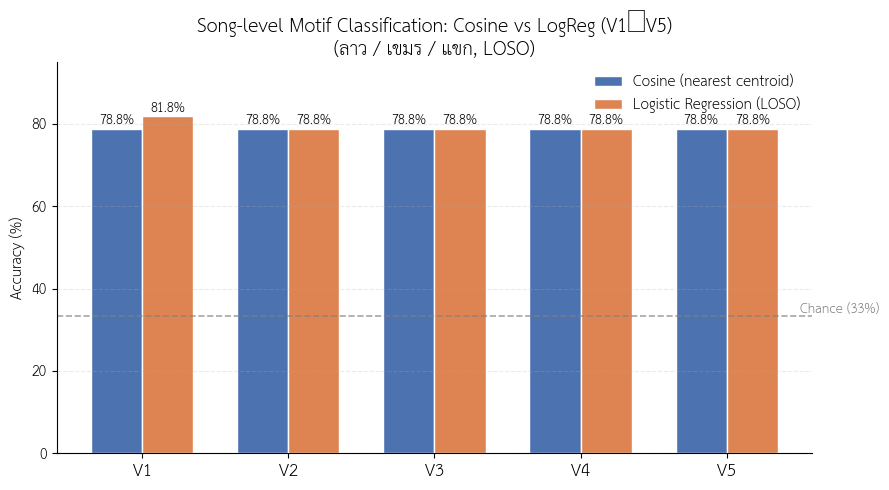

Version      Cosine     LogReg
------------------------------
V1            78.8%      81.8%
V2            78.8%      78.8%
V3            78.8%      78.8%
V4            78.8%      78.8%
V5            78.8%      78.8%


In [85]:
import matplotlib.pyplot as plt
import numpy as np

MOTIF_EN_SONG = {"ลาว": "Laos", "เขมร": "Khmer", "แขก": "Khaek"}

versions    = ["V1", "V2", "V3", "V4", "V5"]
cos_accs    = [cosine_accs[v] * 100 for v in versions]
logreg_accs = [acc_v1 * 100, acc_v2 * 100, acc_v3 * 100, acc_v4 * 100, acc_v5 * 100]
chance      = 100 / 3

x     = np.arange(len(versions))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))

bars1 = ax.bar(x - width/2, cos_accs,    width, label="Cosine (nearest centroid)",
               color="#4C72B0", edgecolor="white")
bars2 = ax.bar(x + width/2, logreg_accs, width, label="Logistic Regression (LOSO)",
               color="#DD8452", edgecolor="white")

for bar in list(bars1) + list(bars2):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, h + 0.4,
            f"{h:.1f}%", ha="center", va="bottom", fontsize=9, fontweight="bold")

ax.axhline(chance, color="gray", linestyle="--", linewidth=1.2, alpha=0.7)
ax.text(len(versions) - 0.5, chance + 0.8, f"Chance ({chance:.0f}%)", color="gray", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(versions, fontsize=12)
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 95)
ax.set_title("Song-level Motif Classification: Cosine vs LogReg (V1→V5)\n(ลาว / เขมร / แขก, LOSO)", fontsize=13)
ax.legend(frameon=False, fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

print(f"{'Version':<8} {'Cosine':>10} {'LogReg':>10}")
print("-" * 30)
for v, c, l in zip(versions, cos_accs, logreg_accs):
    print(f"{v:<8} {c:>9.1f}% {l:>9.1f}%")
